Problem 2: Diffusion Model Explorations (8 points)

As extensively discussed in class, the drift-diffusion model (DDM) generates two response time (RT)
distributions, one for each boundary (i.e., lower and upper boundaries). This exercise asks you to
first explore a somewhat counterintuitive question about the basic DDM: What differences between
the means of the two RT distributions does the the model predict?
To approach this question from a simulation-based perspective, you need to repeatedly solve
the forward problem with different parameter configurations and collect the two summary statistics, namely, the two empirical means of the resulting RT distributions. First, choose a suitable
configuration of the four parameters and vary only the drift rates within a reasonable range (e.g.,
v ∈ [0.5 − 1.5]) for a total of 25 different drift rates. Make sure that your parameterizations can
generate a sufficient number of RTs for both distributions and you don’t end up with the process
only reaching the upper boundary. Second, for each of your parameter configurations, generate
N = 2000 synthetic observations and estimate the means of the two distributions. What do you
observe regarding the mean difference? Describe and interpret your results. (4 points)
In a similar spirit (keeping all parameters fixed and varying one), explore the effects of each of
the parameters on the means and standard deviations of the simulated RT distributions, quantify
and describe your results. (4 points)

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

/tmp/ipykernel_26648/383278000.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
df = pd.read_csv('./data/rt_example_data.csv', delimiter=';')

In [3]:
df.head()

,#TIME,TRIAL,RESPONSE,RT,PRIME,TARGET,TYPE,RESULT,QUESTION
0,82.2292,1,0,0.4851,0,1,incongruent,incorrect,0
1,85.9700,2,0,0.5515,1,0,incongruent,correct,0
2,89.2500,3,1,0.6348,1,0,congruent,incorrect,0
3,92.6600,4,0,0.7683,0,0,congruent,correct,0
4,96.5800,5,1,0.5181,1,1,incongruent,correct,0


In [4]:
from numba import njit
@njit
def simulate_diffusion(v, a, beta, tau, dt=1e-3, scale=1.0, max_time=10.):
    """
    Simulates one realization of the diffusion process given
    a set of parameters and a step size `dt`.

    Parameters:
    -----------
    v     : float
        The drift rate (rate of information uptake)
    a     : float
        The boundary separation (decision threshold).
    beta  : float in [0, 1]
        Relative starting point (prior option preferences)
    tau   : float
        Non-decision time (additive constant)
    dt    : float, optional (default: 1e-3 = 0.001)
        The step size for the Euler algorithm.
    scale : float, optional (default: 1.0)
        The scale (sqrt(var)) of the Wiener process. Not considered
        a parameter and typically fixed to either 1.0 or 0.1.
    max_time: float, optional (default: .10)
        The maximum number of seconds before forced termination.

    Returns:
    --------
    (x, c) - a tuple of response time (y - float) and a 
        binary decision (c - int) 
    """

    # Inits (process starts at relative starting point)
    y = beta * a
    num_steps = tau
    const = scale*np.sqrt(dt)

    # Loop through process and check boundary conditions
    while (y <= a and y >= 0) and num_steps <= max_time:

        # Perform diffusion equation
        z = np.random.randn()
        y += v*dt + const*z

        # Increment step counter
        num_steps += dt

    if y >= a:
        c = 1.
    else:
        c = 0.
    return (round(num_steps, 3), c)

@njit
def simulate_diffusion_n(num_sims, v, a, beta, tau, dt=1e-3, scale=1.0, max_time=10.):
    """Add a nice docstring."""

    data = np.zeros((num_sims, 2))
    for n in range(num_sims):
        data[n, :] = simulate_diffusion(v, a, beta, tau, dt, scale, max_time)
    return data


Drift Rates

In [23]:
params = {
    'v': 1,
    'a': 3,
    'beta': 0.5,
    'tau': 0.7
}

In [24]:
import copy
def simulate_variable_diffusions(num_runs, params, var:str, vals_for_var: list):
    p = copy.deepcopy(params)
    val_data = np.zeros((vals_for_var.shape[0], 3))
    val_data[:,0] = vals_for_var.T
    if var not in p:
        raise ValueError(f"{var} is not a parameter!")
    for idx, value in enumerate(vals_for_var):
        p[var] = value
        data = simulate_diffusion_n(num_runs, **p)
        # add means of correct to table
        val_data[idx, 1] = np.mean(data[data[:, 1] == 0][:, 0])
        # add means of incorrect to table
        val_data[idx, 2] = np.mean(data[data[:, 1] == 1][:, 0])
    return val_data

In [25]:
def visualize_variable_diffusion(data, variable_name, figsize=(12, 4)):
    
    # Creating DataFrame
    df = pd.DataFrame(data, columns=[variable_name, 'Incorrect', 'Correct'])
    
    # Melting DataFrame to plot with seaborn
    df_melted = df.melt(id_vars=variable_name, value_vars=['Incorrect', 'Correct'], var_name='Variable', value_name='Value')
    
    # Plot
    plt.figure(figsize=figsize)
    sns.barplot(data=df_melted, x=variable_name, y='Value', hue='Variable', palette=['gray', 'maroon'])
    plt.xlabel(f"{variable_name} values")
    plt.title("Means based on drift rate")
    plt.ylabel('means')
    plt.legend(title='Variable')
    plt.show()

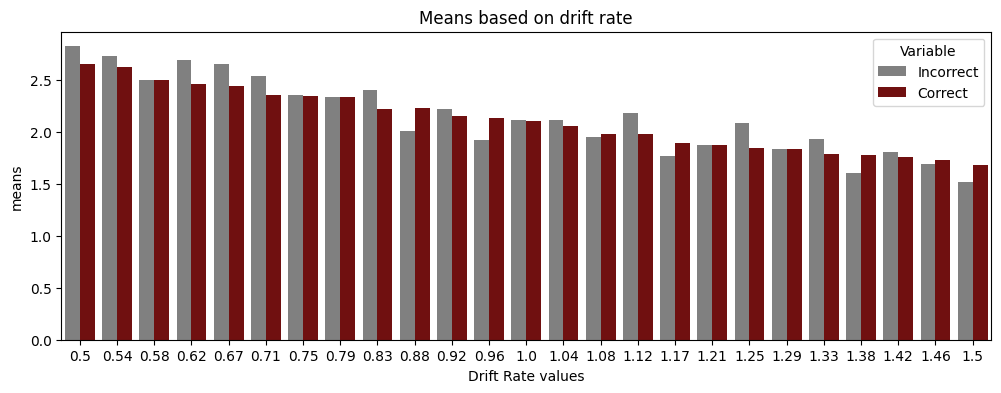

In [26]:
drift_vals = np.around(np.linspace(0.5, 1.5, num=25), 2)
ret = simulate_variable_diffusions(2000, params, 'v', drift_vals)
visualize_variable_diffusion(ret, "Drift Rate")

The drift rate does not affect the mean difference in RT for incorrect and correct responses. As drift rate increases, both correct and incorrect response time decrease.

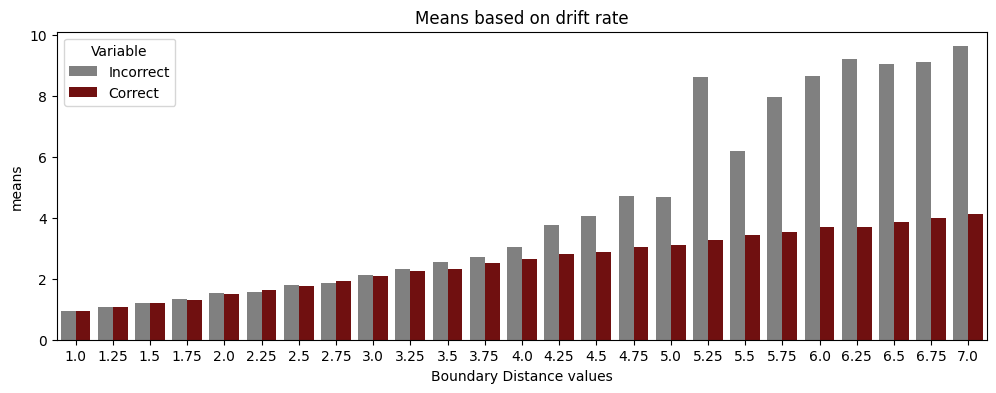

In [39]:
bound_values = np.around(np.linspace(1, 7, num=25), 2)
ret = simulate_variable_diffusions(2000, params, 'a', bound_values)
visualize_variable_diffusion(ret, "Boundary Distance")

The boundary distance affects the mean of the incorrect response times much more than the means of the correct response times. 

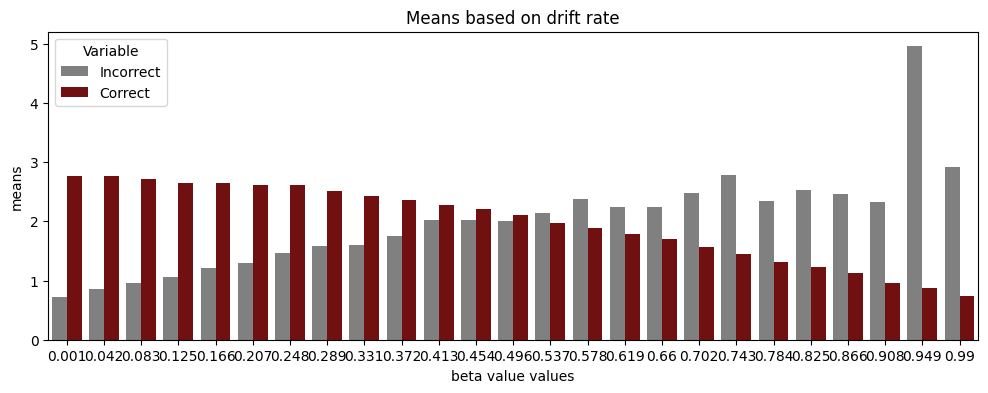

In [36]:
beta_values = np.around(np.linspace(0.001, .99, num=25), 3)
ret = simulate_variable_diffusions(2000, params, 'beta', beta_values)
visualize_variable_diffusion(ret, "beta value")

The beta value affects the means of the correct and incorrect response times inversely. While the correct response times decrease with a greater beta value, the incorrect response times increase. This makes sense - with a greater beta value, the more biased the starting point is, the longer it will take to diffuse to the side that it is biased against.

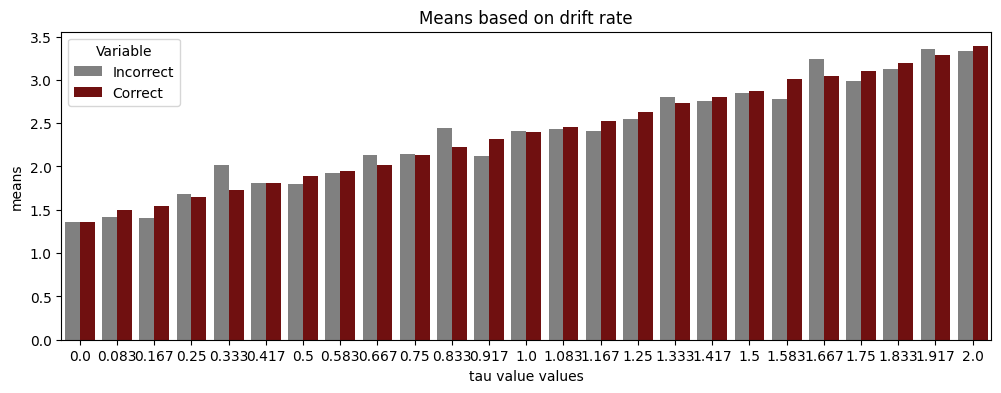

In [32]:
tau_values = np.around(np.linspace(0, 2, num=25), 3)
ret = simulate_variable_diffusions(2000, params, 'tau', tau_values)
visualize_variable_diffusion(ret, "tau value")

The Tau value does not affect the mean difference in RT for incorrect and correct responses.